In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### Keras setup

In [2]:
# convert to one-hot encoding
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


### Data loading

In [3]:
train_file = "data/train.csv"
test_file = "data/test.csv"
output_file = "submission.csv"
model_file = "myMNIST_model.h5"

### Split training data as training set and validation set

In [4]:
raw_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')

# x is data, y is label
x_train, x_val, y_train, y_val = train_test_split(
                                    raw_data[:,1:], 
                                    raw_data[:,0], 
                                    test_size=0.1)
print(len(x_train))
print(len(x_val))

print(len(y_train))
print(len(y_val))

37800
4200
37800
4200


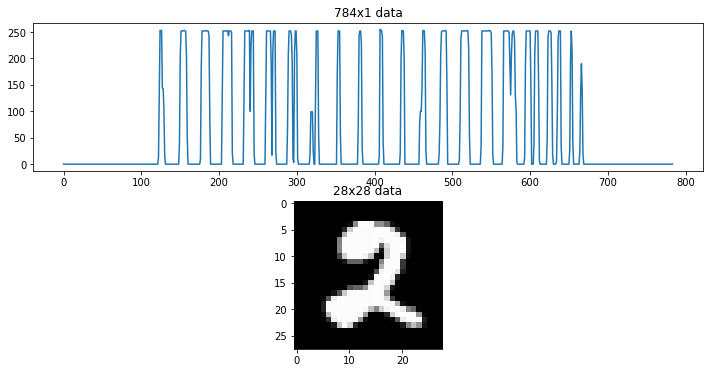

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(12,6))
ax[0].plot(x_train[0])
ax[0].set_title("784x1 data")
ax[1].imshow(x_train[0].reshape(28,28), cmap='gray')
ax[1].set_title("28x28 data")

In [6]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

# convert 0-255 to 0-1, converge faster. why
x_train = x_train.astype("float32")/255.
x_val = x_val.astype("float32")/255.

The labels were given as integers between 0 and 9. We need to convert these to one-hot encoding, i.e. a 10x1 array with one 1 and nine 0:s, with the position of the 1 showing us the value. 

In [7]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
print(y_train[0])

[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


### Network building

BN and Dropout used

In [8]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3), activation='relu', input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


# data augmentation
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)


model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])
# to reduce the learning rate by 10% every epoch.
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=16),
                           steps_per_epoch=500,
                           epochs=50, #Increase this when not on Kaggle kernel
                           verbose=2,  #1 for ETA, 0 for silent
                           validation_data=(x_val[:400,:], y_val[:400,:]), #For speed
                           callbacks=[annealer])

Epoch 1/50
 - 23s - loss: 0.8046 - acc: 0.7410 - val_loss: 0.1136 - val_acc: 0.9650
Epoch 2/50
 - 22s - loss: 0.3187 - acc: 0.9024 - val_loss: 0.1052 - val_acc: 0.9675
Epoch 3/50
 - 23s - loss: 0.2466 - acc: 0.9256 - val_loss: 0.0748 - val_acc: 0.9825
Epoch 4/50
 - 21s - loss: 0.2090 - acc: 0.9400 - val_loss: 0.0776 - val_acc: 0.9775
Epoch 5/50
 - 21s - loss: 0.1715 - acc: 0.9480 - val_loss: 0.0492 - val_acc: 0.9800
Epoch 6/50
 - 19s - loss: 0.1568 - acc: 0.9549 - val_loss: 0.0162 - val_acc: 0.9950
Epoch 7/50
 - 22s - loss: 0.1475 - acc: 0.9564 - val_loss: 0.0300 - val_acc: 0.9900
Epoch 8/50
 - 23s - loss: 0.1296 - acc: 0.9610 - val_loss: 0.0350 - val_acc: 0.9900
Epoch 9/50
 - 21s - loss: 0.1296 - acc: 0.9649 - val_loss: 0.0212 - val_acc: 0.9950
Epoch 10/50
 - 21s - loss: 0.1029 - acc: 0.9690 - val_loss: 0.0144 - val_acc: 0.9925
Epoch 11/50
 - 22s - loss: 0.0906 - acc: 0.9747 - val_loss: 0.0216 - val_acc: 0.9925
Epoch 12/50
 - 22s - loss: 0.1026 - acc: 0.9667 - val_loss: 0.0107 - val_a

## Evaluation

To check performance on whole dataset

In [9]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose = 2)
print("Final loss: {0:0.4f},  Final Accuracy: {1:0.4f}".format(final_loss, final_acc))

Final loss: 0.0202,  Final Accuracy: 0.9938


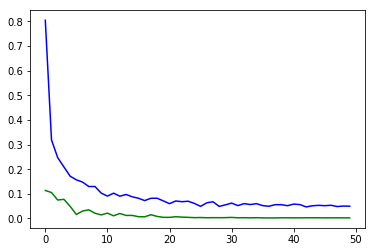

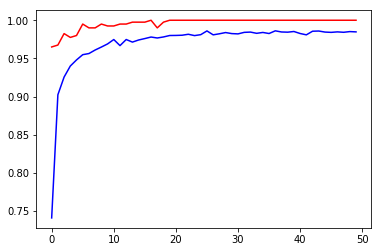

In [10]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='g')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [11]:
model.save(model_file)

## Submit

Output results

In [12]:
mnist_testset = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')
x_test = mnist_testset.astype("float32")
x_test = x_test.reshape(-1, 28, 28, 1) / 255.
y_hat = model.predict(x_test, batch_size=64) #  Probabilities correspoinding to the one-hot encoding

In [14]:
# Select max probability
y_pred = np.argmax(y_hat, axis=1)

In [15]:
with open(output_file, 'w') as f:
    f.write('ImageId, Label\n')
    for i in range(len(y_pred)):
        f.write("".join([str(i+1),',',str(y_pred[i]),'\n']))

# Result

- Kaggle test result: 99.471%
- Ranking: 300+/2240 (17%)
    
If I train this all night and fine-turn, the result would be better for sure.
But, it is unnecessary to waste time.